# The Modifiable Areal Unit Problem

## The MAUP
At this point, it should be clear that you have choices when it comes to how to prepare, analyze, summarize, and report geographic data.  For instance, you may choose to conduct analysis using population summaries for individual states vs using population summaries for individual counties. Will the results of these analyses indicate similar or different findings?  Who knows given MAUP is at work.  The only way to find out is to repeat the same analysis using different geospatial representations of the problem and take note as to where and how similiarities and differences manifest.

In [1]:
# Load relevant R packages
inLibraries = list('rgdal','spdep','classInt','RColorBrewer','geoR')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}

Warning message:
“no DISPLAY variable so Tk is not available”

## Spatial Autocorrelation in Cancer Incidence Rates

In this practice, we will again work with the New York Cancer Registry dataset. Details regarding this registry can be found at (https://www.health.ny.gov/statistics/cancer/registry/Read). This particular dataset reflects information on the spatial distribution of incidence of prostate cancer as summarized at the ZIP code level (https://www.health.ny.gov/statistics/cancer/registry/zipcode/index.htm). 

While that's all well and good, what determines whether a location is part of a ZIP code is generally something that is not well understood.  In fact, a location is only associated with a ZIP code in the event that it is a legitimate mailing address in the U.S.  That is, it needs to be associated with a state, a city within a state, and then a street name (or P.O. box) and a numeric identifier along the street.  In essence, ZIP codes only exist along streets...no where else!  As such, why do ZIP code 'areas' exists?  It's just easier for us simple humans to understand them in that form.

It gets even more complicated from here.  As it turns out, given that ZIP codes are defined along roads, there are many cases in which roads can be close to one another, but are associated with different ZIP codes. For example, in large cities, one building may have it's own ZIP code, different from that of the roads that surround it.  As such, ZIP codes can be point features in some cases. Also, ZIP codes are not always contiguous. That is, there is no requirement that roads assigned to a ZIP code be adjacent, not separated by roads associated with other ZIP codes. Given all of this, if one wishes to create ZIP code 'areas', some interpolation is required. There have been many attempts by different agencies and companies to interpolate ZIP code areas.  In some cases, their ZIP code areas align, but in other cases, they can be very different.

While ZIP codes are geographically difficult for many to deal with, they are convienent in many respects.  For example, when conducting surveys, it is very easy to request a ZIP code from a respondent as a ZIP code is aggregate enough to conceal personally identifiable information. Therefore, ZIP codes are very common reporting units for data collection efforts.  Given the problems in defining ZIP codes, the Census Bureau sensed some sigificant census related could arise.  In particular, after collecting all that data at the ZIP code level, people now wanted all of the socio-economic-demographic data associated with the ZIP code...in other words, they wanted Census data which was not collected/tabulated for ZIP codes.  As such, the Census Bureau was kind enough to attempt to rememdy the issue by creating what are now known as ZCTAs (ZIP Code Tabulation Areas) - read more about it here https://www.census.gov/geo/reference/zctas.html.  In essence, ZCTAs are estimated areas for ZIP codes that also take into account locations not having any postal addresses (i.e. public land, water bodies, etc.).

You can find the ZIP code polygons and the associated prostate cancer data at (newyork_cancer/NYzipUTM.shp). You can find the ZCTA polygons and the associated prostate cancer data at (newyork_cancer/NYzctaUTM.shp).  Next, read in the shp file. Also, it's always a good idea to examine the structure of the dataset (has not been done for you below).

See the article by Matisziw et al. (2008) in the reading list. They also conduct some comparisons of using the New York cancer registry datasets.

In [3]:
#Read in the featureclasses
inFeaturesA <- readOGR("/dsa/data/geospatial/DS8612/newyork_cancer","NYzipUTM")

inFeaturesB <- readOGR("/dsa/data/geospatial/DS8612/newyork_cancer","NYzctaUTM")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/newyork_cancer", layer: "NYzipUTM"
with 1384 features
It has 9 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/newyork_cancer", layer: "NYzctaUTM"
with 2450 features
It has 12 fields


In [4]:
head(inFeaturesA@data)

,PRIMARY,COUNT,MalePop,ObsIncid,CRate,test,CRate2,crate3,AfAm
0,0,3,0,0,0.000000000,0,NA,NA,0
1,10001,1,9570,54,0.005642633,0,0.00564263,0.00564263,1897
2,10002,1,37830,190,0.005022469,0,0.00502247,0.00502247,6836
3,10003,1,25524,160,0.006268610,0,0.00626861,0.00626861,1977
4,10005,3,2283,9,0.003942181,0,0.00394218,0.00394218,242
5,10007,1,5256,13,0.002473364,0,0.00247336,0.00247336,471


In [5]:
head(inFeaturesB@data)

,AREA,PERIMETER,ZCTA,NAME,COUNT,ObsIncid,MalePop,CRate,df,lat,long,AfAm
0,0.01865,6.17557,136,136HH,1189,0,0,0.000000000,0,4952764,471946.8,NA
1,0.01144,1.08048,13662,13662,2085,80,5778,0.013845621,0,4977063,505876.4,84
2,0.04241,4.83010,129,129HH,632,0,0,0.000000000,0,4930811,628844.4,NA
3,0.00171,0.31698,12979,12979,176,8,820,0.009756098,0,4982809,628092.7,19
4,0.01131,0.70558,12919,12919,451,11,1113,0.009883199,0,4980181,621818.2,3
5,0.01020,0.51160,12958,12958,233,7,698,0.010028653,0,4978992,612546.3,3


## Feature Attributes to Analyze

In most geostatistical methods, an attribute(s) of a feature is to be analysed/displayed. For the New York dataset, we are evaluating prostate cancer incidence 'ObsIncid' which is the number of recorded occurences in the resident population. Given that the population can vary among the reporting areas (ZIP and ZCTA areas in this case), it might be good to normalize the observations of cancer by the population of each area....something known as population density. However, since prostate cancer is likely limited to males, we can limit the population to the male population 'MalePop'.

In [6]:
inVa <- inFeaturesA@data$ObsIncid
inVb <-inFeaturesB@data$ObsIncid

inVc <- inFeaturesA@data$MalePop
inVd <-inFeaturesB@data$MalePop

In [7]:
inVa[1:5]

[1]   0  54 190 160   9

In [8]:
#analysis rate variables
inFeaturesA@data$VarA <- inVa/inVc
inFeaturesB@data$VarB <- inVb/inVd

In [9]:
inFeaturesA@data$VarA[1:5]

[1]         NaN 0.005642633 0.005022469 0.006268610 0.003942181

In [10]:
#make sure to deal with nulls if present
inFeaturesA@data$VarA[is.na(inFeaturesA@data$VarA)] <- 0
inFeaturesB@data$VarB[is.na(inFeaturesB@data$VarB)] <- 0

In [11]:
inFeaturesA@data$VarA[1:5]

[1] 0.000000000 0.005642633 0.005022469 0.006268610 0.003942181

## Plot Observed Data for Both Geographies

Plot the cancer incidence as rendered using ZIP code polygons and ZCTA polygons.  Even though the both represent the spatial extent of ZIP codes, they look a little different .... right?

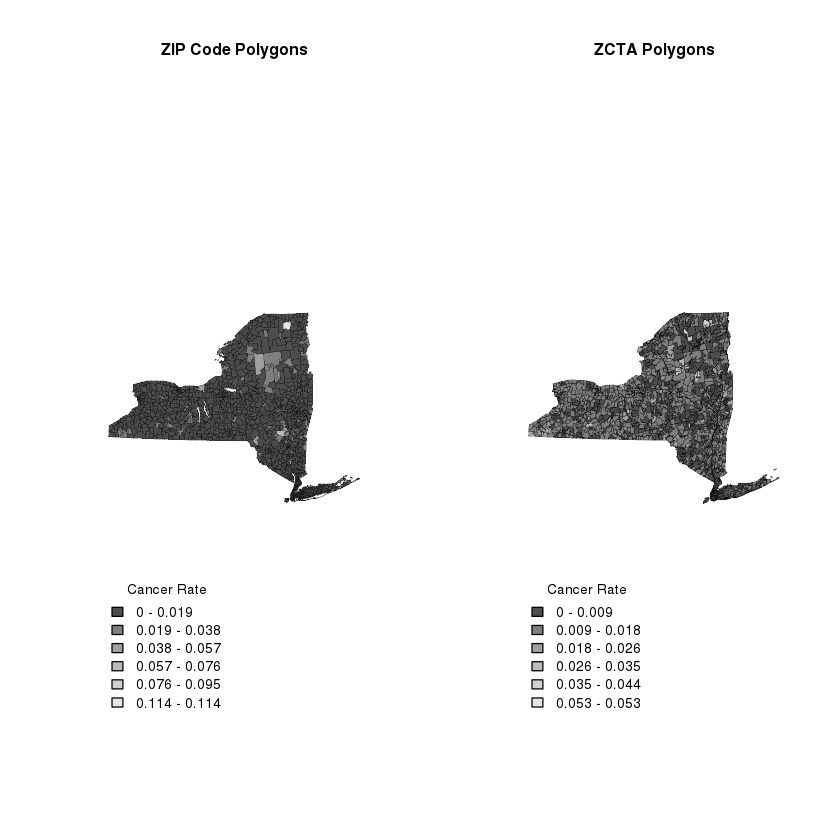

In [12]:
par(mfrow=c(1,2))

#plot zip code areas
#Configure classification parameters
numcat <- 6
cate <- classIntervals(inFeaturesA@data$VarA, numcat, style="equal")

#assign colors to categories
pal <- gray.colors(numcat)
cols <- findColours(cate,pal)

#Map classification scheme
decimalPlaces <- 3
plot(inFeaturesA,col=cols, lwd=.2, main="ZIP Code Polygons",cex.main=.8)
brks.dec <- round(cate$brks,decimalPlaces)
leg.text <- paste(brks.dec[-numcat], brks.dec[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Cancer Rate",cex=.7)

# -------------------------------------------------------

#plot zcta areas
numcat <- 6
cate <- classIntervals(inFeaturesB@data$VarB, numcat, style="equal")

#assign colors to categories
pal <- gray.colors(numcat)
cols <- findColours(cate,pal)

#Map classification scheme
decimalPlaces <- 3
plot(inFeaturesB,col=cols, lwd=.2, main="ZCTA Polygons",cex.main=.8)
brks.dec <- round(cate$brks,decimalPlaces)
leg.text <- paste(brks.dec[-numcat], brks.dec[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Cancer Rate",cex=.7)

### Compute Neighborhoods of Both Geographies

Next, compute the neighborhood associated with polygons in both datasets.

In [13]:
#Identify the neighbors of each feature
inFeaturesA.nb <- poly2nb(inFeaturesA,queen=TRUE)

#Select features with at least one neighbor
inFeaturesA <- inFeaturesA[card(inFeaturesA.nb) >= 1, ]

#Identify the neighbors of each feature having at least one neighbor
inFeaturesA.nb <- poly2nb(inFeaturesA, queen=TRUE)
inFeaturesA.nb.self <- include.self(inFeaturesA.nb)

#Retrieve neighborhood list
inFeaturesA.listb <- nb2listw(inFeaturesA.nb,style="B")
inFeaturesA.listw <- nb2listw(inFeaturesA.nb,style="W")
inFeaturesA.listb.self <- nb2listw(inFeaturesA.nb.self,style="B")
inFeaturesA.listw.self <- nb2listw(inFeaturesA.nb.self,style="W")

In [14]:
#Identify the neighbors of each feature
inFeaturesB.nb <- poly2nb(inFeaturesB,queen=TRUE)

#Select features with at least one neighbor
inFeaturesB <- inFeaturesB[card(inFeaturesB.nb) >= 1, ]

#Identify the neighbors of each feature having at least one neighbor
inFeaturesB.nb <- poly2nb(inFeaturesB, queen=TRUE)
inFeaturesB.nb.self <- include.self(inFeaturesB.nb)

#Retrieve neighborhood list
inFeaturesB.listb <- nb2listw(inFeaturesB.nb,style="B")
inFeaturesB.listw <- nb2listw(inFeaturesB.nb,style="W")
inFeaturesB.listb.self <- nb2listw(inFeaturesB.nb.self,style="B")
inFeaturesB.listw.self <- nb2listw(inFeaturesB.nb.self,style="W")

### Assess Spatial Autocorrelation

Given the spatial structure of these two datasets, compute the Moran statistic. It is significant in both datasets indicating that spatial autocorrelation is likely present. However, note that the Moran statistic is much closer to zero for the ZCTAs.

In [16]:
#run autocorrelation tests
moran.test(inFeaturesA@data$VarA, inFeaturesA.listb)


	Moran I test under randomisation

data:  inFeaturesA@data$VarA  
weights: inFeaturesA.listb  

Moran I statistic standard deviate = 9.5593, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.1538994467     -0.0007246377      0.0002616391 


In [17]:
moran.test(inFeaturesB@data$VarB, inFeaturesB.listb)


	Moran I test under randomisation

data:  inFeaturesB@data$VarB  
weights: inFeaturesB.listb  

Moran I statistic standard deviate = 6.5202, p-value = 3.511e-11
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.0806278593     -0.0004091653      0.0001544715 


### Compute the Gi for the ZIP code polygons

Compute the Gi statistic. After that, compute a spatial autoregressive model to estimate the rho parameter and use that to estimate ESS. Finally, find the z-scores that are associated with the desired confidence levels.

In [18]:
#Compute local Gi* statistic
Afeat.Gi <- localG(inFeaturesA@data$VarA,inFeaturesA.listb.self)

#Compute effective sample size
feat.d.sar <- errorsarlm(inFeaturesA@data$VarA ~1, listw=inFeaturesA.listw)
rho <- feat.d.sar$lambda
rho2 <- unname(rho)

#compute set size of observed z-score distribution
dvalues <- length(inFeaturesA)

#Calculated effective sample size per Griffith's (2005) eq.
ESSA <- dvalues * (1-(1/(1-exp(-1.92349)))*((dvalues-1)/dvalues)*(1-exp((-2.12373*rho2)+ (.20024*sqrt(rho2)))))
paste("ESS =",ESSA,sep=" ")

#list of adjusted normal z-score breakpts
zAdjusted <- list()

#find z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95)

#compute higher levels
i <- 1
for (pr in probsU) {    
    rmean <- mean(inFeaturesA@data$VarA)
    newpr <- 1-(((1-pr)/ESSA)/2)
    
    #compute error according to adjusted normal distribution
    errorN <- qnorm(newpr,mean=rmean,lower.tail=TRUE)
    zAdjusted[[i]] <-0 + errorN   
      
    i <- i+1
}

AzcG <- unlist(zAdjusted)
#for each confidence level, print the confidence level and corresponding z-score
paste(probsU,AzcG,sep="   ")

[1] "ESS = 667.844095917588"

[1] "0.9   3.80313917456379" "0.95   3.9718929172627"

### Compute the Gi for the ZCTA polygons

Compute the Gi statistic. After that, compute a spatial autoregressive model to estimate the rho parameter and use that to estimate ESS. Finally, find the z-scores that are associated with the desired confidence levels.

In [19]:
#Compute local Gi* statistic
Bfeat.Gi <- localG(inFeaturesB@data$VarB,inFeaturesB.listb.self)

#Compute effective sample size
feat.d.sar <- errorsarlm(inFeaturesB@data$VarB ~1, listw=inFeaturesB.listw)
rho <- feat.d.sar$lambda
rho2 <- unname(rho)

#compute set size of observed z-score distribution
dvalues <- length(inFeaturesB)

#Calculated effective sample size per Griffith's (2005) eq.
ESSB <- dvalues * (1-(1/(1-exp(-1.92349)))*((dvalues-1)/dvalues)*(1-exp((-2.12373*rho2)+ (.20024*sqrt(rho2)))))
paste("ESS =",ESSB,sep=" ")

#list of adjusted normal z-score breakpts
zAdjusted <- list()

#find z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95)

#compute higher levels
i <- 1
for (pr in probsU) {    
    rmean <- mean(inFeaturesB@data$VarB)
    newpr <- 1-(((1-pr)/ESSB)/2)
    
    #compute error according to adjusted normal distribution
    errorN <- qnorm(newpr,mean=rmean,lower.tail=TRUE)
    zAdjusted[[i]] <-0 + errorN   
      
    i <- i+1
}

BzcG <- unlist(zAdjusted)
#for each confidence level, print the confidence level and corresponding z-score
paste(probsU,BzcG,sep="   ")

[1] "ESS = 2290.24451731891"

[1] "0.9   4.09609037944615"  "0.95   4.25418648994489"

## Comparison (Gi*)

It should be clear at this point that the ZIP and ZCTA datasets are different. Also, statistics computed using the two datasets are different - i.e. Moran statistic, rho, ESS, etc. Let's try and visualize similiarities and differences in the distribution of the Gi values over the study area.

To do this plot a side-by-side comparison of the Gi z-values obtained using the ZIP vs ZCTA topologies.  The ZIP analysis indicates significant autocorrelation of areas with higher cancer incidence in many cases.  However, the ZCTA analysis suggests almost a totally different pattern of spatial clustering.  Which one is correct?  Depends on which message you wish to report...sketchy right?  Moreover, it depends on the extent to which you believe on representation is more reflective of reality than the other.

Regardless, one comparison that can be beneficial in this case is to report which areas have similiar and different clustering values in each of the datasets.  For example, an area in the southwestern portion of the state and a small area in the northeastern portion of the state are classified as significant clustering of high values in both the ZIP and ZCTA analysis.  So, in that instance, even though we changed the areal units of analysis, the implication was the same...which gives us more confidence in reporting the result.  

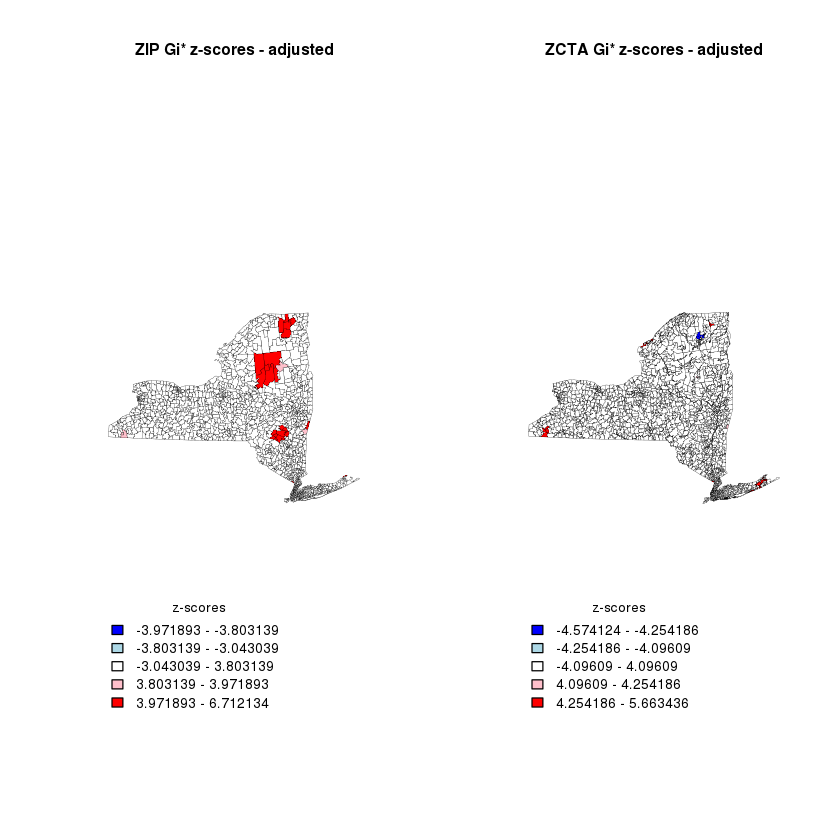

In [20]:
par(mfrow=c(1,2))

#Plot ZIP code areas
#classify adjusted Gi* z-score significance 
Anczc1 <- 4 + length(AzcG) - 1
Anczc2 <- 4 + length(AzcG)
Az.Gi <- classIntervals(Afeat.Gi,n=Anczc1, style="fixed",fixedBreaks=c(min(Afeat.Gi), -AzcG, AzcG, max(Afeat.Gi)))

#plot values
pal <- c("blue","lightblue","white","pink","red")
cols.Gi <- findColours(Az.Gi, pal)
plot(inFeaturesA, col=cols.Gi,lwd=.2,main="ZIP Gi* z-scores - adjusted",cex.main=.8)
brks <- round(Az.Gi$brks, Anczc2)
leg <- paste(brks[-Anczc2], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="z-scores",cex=.7)

# -------------------------------------------------------------------------------

#Plot ZCTA areas
#classify adjusted Gi* z-score significance 
Bnczc1 <- 4 + length(BzcG) - 1
Bnczc2 <- 4 + length(BzcG)
Bz.Gi <- classIntervals(Bfeat.Gi,n=Bnczc1, style="fixed",fixedBreaks=c(min(Bfeat.Gi), -BzcG, BzcG, max(Bfeat.Gi)))

#plot values
pal <- c("blue","lightblue","white","pink","red")
cols.Gi <- findColours(Bz.Gi, pal)
plot(inFeaturesB, col=cols.Gi,lwd=.2,main="ZCTA Gi* z-scores - adjusted",cex.main=.8)
brks <- round(Bz.Gi$brks, Bnczc2)
leg <- paste(brks[-Bnczc2], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="z-scores",cex=.7)

## Issues with ZCTAs

Now there is a little nuiance with ZCTAs that's worth mentioning.  Some ZCTA polygons are areas that have no postal addresses - i.e. may be bodies of water or unihabitated areas. The question is then: how do we treat these...leave them in which would affect the representation of contiguity and maybe even bias any measures we'd compute such as autocorrelation or take them out?  Let's take them out.  The problem areas in question are those whose name does not contain a 'HH' or 'XX'.  One way to remove them is to select out only those labeled as HH or XX.  Another way is to select only areas having some population.  

Below, the latter criteria is used, but some code is also included to show how one might select based on the name not containing HH or XX. Given we are modifying the structure of the dataset, remember that the neighborhoods will also need to be re-computed.

In [21]:
#Select features 
inFeaturesBnotzero <- inFeaturesB[!inFeaturesB@data$MalePop == 0,]

#compare number of features with that of original dataset
length(inFeaturesB)
length(inFeaturesBnotzero)

#Alternative selection criteria
#Select features that are not HH or XX
#criteria <- c("HH", "XX")
#inFeaturesBselect <- (grep(paste(criteria,collapse="|"), 
#                        inFeaturesB@data$NAME, value=TRUE))
#inFeaturesBSubset <- inFeaturesB[!inFeaturesB@data$NAME %in% inFeaturesBselect,]

#Identify the neighbors of each feature
inFeaturesBnotzero.nb <- poly2nb(inFeaturesBnotzero ,queen=TRUE)

#Select features with at least one neighbor
inFeaturesBnotzero <- inFeaturesBnotzero[card(inFeaturesBnotzero.nb) >= 1, ]

#Identify the neighbors of each feature having at least one neighbor
inFeaturesBnotzero.nb <- poly2nb(inFeaturesBnotzero, queen=TRUE)
inFeaturesBnotzero.nb.self <- include.self(inFeaturesBnotzero.nb)

#Retrieve neighborhood list
inFeaturesBnotzero.listb <- nb2listw(inFeaturesBnotzero.nb,style="B")
inFeaturesBnotzero.listw <- nb2listw(inFeaturesBnotzero.nb,style="W")
inFeaturesBnotzero.listb.self <- nb2listw(inFeaturesBnotzero.nb.self,style="B")
inFeaturesBnotzero.listw.self <- nb2listw(inFeaturesBnotzero.nb.self,style="W")

[1] 2445

[1] 1993

### Assess Autocorrelation

Given the modified ZCTA dataset, apply the Moran test to see if the level of autocorrelation has been affected by the modification. It has! That's MAUP for you.  Nothing's shocking anymore.

In [22]:
#run autocorrelation tests
moran.test(inFeaturesBnotzero@data$VarB, inFeaturesBnotzero.listb)


	Moran I test under randomisation

data:  inFeaturesBnotzero@data$VarB  
weights: inFeaturesBnotzero.listb  

Moran I statistic standard deviate = 15.654, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.2359573372     -0.0005488474      0.0002282670 


### Recompute Gi Statistic for Modified ZCTAs

Given the ZCTA data was modified, the Gi statistic needs to be recomputed and adjusted for the desired confidence levels.

In [23]:
#Compute local Gi* statistic
BPfeat.Gi <- localG(inFeaturesBnotzero@data$VarB,inFeaturesBnotzero.listb.self)

#Compute effective sample size
feat.d.sar <- errorsarlm(inFeaturesBnotzero@data$VarB ~1, listw=inFeaturesBnotzero.listw)
rho <- feat.d.sar$lambda
rho2 <- unname(rho)

#compute set size of observed z-score distribution
dvalues <- length(inFeaturesBnotzero)

#Calculated effective sample size per Griffith's (2005) eq.
ESSBP <- dvalues * (1-(1/(1-exp(-1.92349)))*((dvalues-1)/dvalues)*(1-exp((-2.12373*rho2)+ (.20024*sqrt(rho2)))))
paste("ESS =",ESSBP,sep=" ")

#list of adjusted normal z-score breakpts
zAdjusted <- list()

#find z-scores corresponding to each of these levels of confidence
probsU <- c(0.90, 0.95)

#compute higher levels
i <- 1
for (pr in probsU) {    
    rmean <- mean(inFeaturesBnotzero@data$VarB)
    newpr <- 1-(((1-pr)/ESSBP)/2)
    
    #compute error according to adjusted normal distribution
    errorN <- qnorm(newpr,mean=rmean,lower.tail=TRUE)
    zAdjusted[[i]] <-0 + errorN   
      
    i <- i+1
}

BPzcG <- unlist(zAdjusted)
#for each confidence level, print the confidence level and corresponding z-score
paste(probsU,BPzcG,sep="   ")

[1] "ESS = 644.539073858793"

[1] "0.9   3.7935466432129"   "0.95   3.96263937920457"

## Comparison of ZCTA Representations

So, what happened when the ZCTAs having no population were removed from the analysis? The first thing that happened is that the number of neighbors were likely reduced for many ZCTAs given that some polygons with no population were no longer being considered. Although it may seem like this was just minor change, note that it impacts the results considerably. First, the level of autocorrelation changes as reflected by the change in the Moran test. Second, the ESS is changed with significance levels. Third, the overall nature of the clustering detected changes. Note, there are very few if any areas in the ZCTA representation that share the same level of significant clustering!

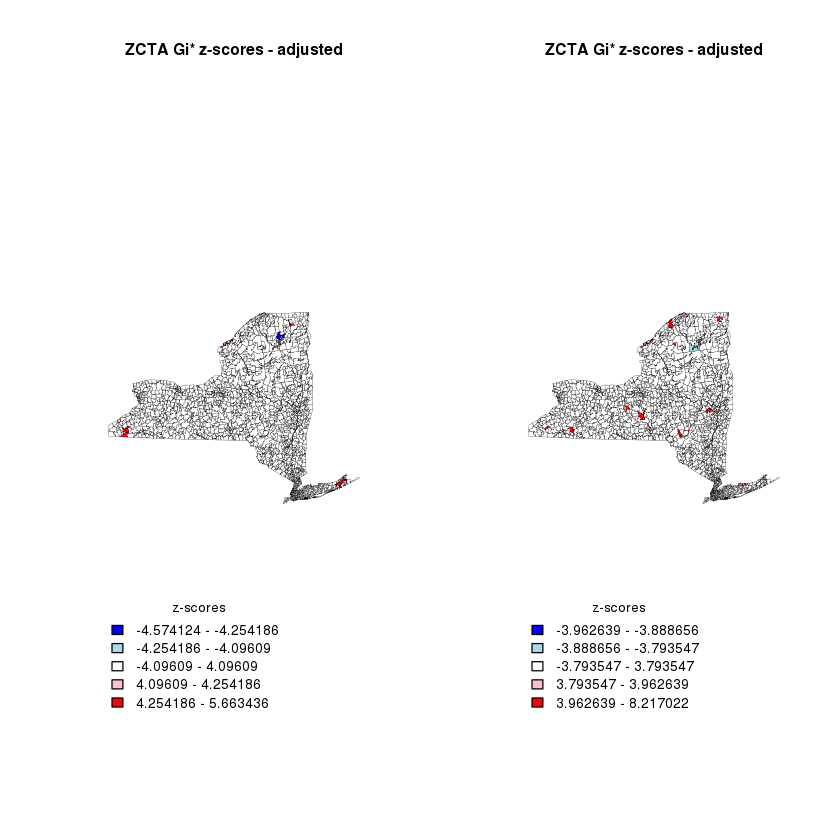

In [24]:
par(mfrow=c(1,2))

#Plot ZCTA areas (with unpopulated areas)
#classify adjusted Gi* z-score significance 
Bnczc1 <- 4 + length(BzcG) - 1
Bnczc2 <- 4 + length(BzcG)
Bz.Gi <- classIntervals(Bfeat.Gi,n=Bnczc1, style="fixed",fixedBreaks=c(min(Bfeat.Gi), -BzcG, BzcG, max(Bfeat.Gi)))

#plot values
pal <- c("blue","lightblue","white","pink","red")
cols.Gi <- findColours(Bz.Gi, pal)
plot(inFeaturesB, col=cols.Gi,lwd=.2,main="ZCTA Gi* z-scores - adjusted",cex.main=.8)
brks <- round(Bz.Gi$brks, Bnczc2)
leg <- paste(brks[-Bnczc2], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="z-scores",cex=.7)

# ---------------------------------------------------------------------

#Plot ZCTA areas (without unpopulated areas)
#classify adjusted Gi* z-score significance 
BPnczc1 <- 4 + length(BPzcG) - 1
BPnczc2 <- 4 + length(BPzcG)
BPz.Gi <- classIntervals(BPfeat.Gi,n=BPnczc1, style="fixed",fixedBreaks=c(min(BPfeat.Gi), -BPzcG, BPzcG, max(BPfeat.Gi)))

#plot values
pal <- c("blue","lightblue","white","pink","red")
cols.Gi <- findColours(BPz.Gi, pal)
plot(inFeaturesB, col=cols.Gi,lwd=.2,main="ZCTA Gi* z-scores - adjusted",cex.main=.8)
brks <- round(BPz.Gi$brks, BPnczc2)
leg <- paste(brks[-BPnczc2], brks[-1], sep=" - ")
legend("bottomleft", fill=pal, legend=leg, bty="n",title="z-scores",cex=.7)

### Implementation Considerations

Wow, repeating this analysis for different datasets sure involved a lot of code.  Most of this code was more or less simply repetition. As such, in practice one might want to consider implementating this type of comparative routine as a loop.